# TFG FER

Este notebook contiene el código necesario para la creación de un modelo de clasificación de imágenes de rostros humanos en función del estres emocional que presentan. Para ello, se va a utuilzar un dataset de imágenes pero de tipo .npy que contiene las imágenes de los rostros pero con un formato diferente al habitual, ya que las imágenes están en formato de matriz de píxeles. 

Los pasos a seguir para la creación del modelo son los siguientes:

1. Importar las librerías necesarias
2. Cargar el dataset
3. Preprocesamiento de los datos
4. Creación del modelo
5. Entrenamiento del modelo
6. Evaluación del modelo
7. Guardar el modelo

In [1]:
import os
import tensorflow as tf

# Configurar TensorFlow para que use la CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Ahora, al crear sesiones de TensorFlow, solo se usará la CPU
# Verificar que realmente no estamos utilizando ninguna GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-09-03 21:38:24.083633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 21:38:24.945873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/envs/myenv/lib/
2024-09-03 21:38:24.945978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/

Num GPUs Available:  0


2024-09-03 21:38:25.920332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-03 21:38:25.920364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Poseidon): /proc/driver/nvidia/version does not exist


## 1. Importar las librerías necesarias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Comprobar version tensorflow
print(tf.__version__)

# Comprobar que estamos usando la GPU
print(tf.config.list_physical_devices())

2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 2. Cargar el dataset

Como se ha mencionado anteriormente, el dataset que se va a utilizar es un archivo .npy que contiene las imágenes de los rostros en formato de matriz de píxeles. Para cargar el dataset, se utiliza la función `np.load()` de la librería NumPy.

Nuestro dataset esta dividido en dos partes, una con las imágenes y otra con las etiquetas. Para la recolección de imágenes se ha utilizado un dataset cuyo escenario experimental consiste en pasos que causan o no causan estrés; lectura de escritura en el idioma nativo, entrevista en el idioma nativo, lectura de escritura en idioma no nativo, entrevista en idioma no nativo.

Por lo tanto las distintas carpetas que forma el dataset son:

- **Native_Language_Script_Reading** (NO STRESS)
- **Native_Language_Interview** (NO STRESS-NEUTRAL)
- **Non_Native_Language_Script_Reading** (STRESS)
- **Non_Native_Language_Interview** (STRESS-NEUTRAL)

Para procesar archivos .npy de la manera que se ha descrito y asignar las etiquetas correspondientes (como "NO STRESS-NEUTRAL", "NO STRESS", "STRESS", "STRESS-NEUTRAL") basadas en el nombre de la carpeta en la que se encuentran, se van a seguir los siguientes pasos:

### 2.1 Asignar las etiquetas a las imágenes

Para asignar las etiquetas a las imágenes, se va a utilizar una primero una función que recorra las carpetas del dataset y asigne las etiquetas correspondientes a cada imagen.

In [3]:
def asignar_etiqueta(nombre_carpeta):
    if nombre_carpeta == "Native_Language_Interview":
        return "NO STRESS-NEUTRAL"
    elif nombre_carpeta == "Native_Language_Script_Reading":
        return "NO STRESS"
    elif nombre_carpeta == "Non-native_Language_Interview":
        return "STRESS"
    elif nombre_carpeta == "Non-native_Language_Script_Reading":
        return "STRESS-NEUTRAL"
    else:
        return None  # Por si el nombre de la carpeta no coincide

### 2.2 Cargar las imágenes y las etiquetas

Para el dataset que se va a utilizar, se van a cargar las imágenes de distintas carpetas, segun la persona que aparece en la imagen, y las etiquetas correspondientes a cada imagen. Dentro de cada carpeta de cada persona, se encuentran las carpetas con las clases de estrés correspondientes, y dentro de cada una de estas carpetas se encuentran las imágenes. Lo que se va a realizar es cargar las imágenes y las etiquetas de cada una de las carpetas de las clases de estrés, y se van a guardar todas las corresponientes a cada persona en un array de numpy. Para asi tener un array de numpy con todas las imágenes y otro con todas las etiquetas.

Es importante destacar que se va a añadir otra lista llamada sujetos, que contendrá el nombre de la persona a la que pertenece cada imagen. Esto se va a realizar para poder separar el dataset en train y test de manera que no se mezclen las imágenes de una misma persona en ambos conjuntos.

In [4]:
# Definir la ruta base de tu DATASET
ruta = "DATASET"

# Definir las subcarpetas que corresponden a cada clase
classes = ["Native_Language_Script_Reading", "Native_Language_Interview",
           "Non-native_Language_Script_Reading", "Non-native_Language_Interview"]

# Número deseado de imágenes por clase
num_images_per_class = 400

# Listas para almacenar las imágenes, las etiquetas y los sujetos
imagenes = []
etiquetas = []
sujetos = []

# Recorrer cada persona en el dataset
for carpeta_persona in sorted(os.listdir(ruta)):
    ruta_persona = os.path.join(ruta, carpeta_persona)
    print(ruta_persona)
    if os.path.isdir(ruta_persona):  # Asegurar que es un directorio
        # Recorrer cada clase
        for cls in classes:
            ruta_clase = os.path.join(ruta_persona, cls)
            if os.path.exists(ruta_clase):
                # Lista todas las imágenes (archivos .npy) en la carpeta de la clase
                images = [os.path.join(ruta_clase, img) for img in sorted(os.listdir(ruta_clase)) if img.endswith(".npy")]        
                # Seleccionar 1000 imágenes aleatorias sin repetición
                if len(images) >= num_images_per_class:
                    selected_images = random.sample(images, num_images_per_class)
                else:
                    selected_images = images  # Si hay menos de 1000, tomar todas
                
                # Añadir las imágenes seleccionadas y sus etiquetas a las listas
                for ruta_imagen in selected_images:
                    imagen = np.load(ruta_imagen, allow_pickle=True)
                    imagenes.append(imagen)
                    etiquetas.append(asignar_etiqueta(cls))
                    sujetos.append(carpeta_persona)
                    
# Contar etiquetas por clase
conteo_etiquetas = {etiqueta: etiquetas.count(etiqueta) for etiqueta in set(etiquetas)}

# Número de etiquetas creadas por clase
for etiqueta, conteo in conteo_etiquetas.items():
    print(f"Etiqueta '{etiqueta}': {conteo} imágenes")

# Comprobar que se cargaron las imágenes correctamente en la lista de sujetos
conteo_sujetos = {sujeto: sujetos.count(sujeto) for sujeto in set(sujetos)}
# Ordenar los sujetos antes de imprimir
for sujeto in sorted(conteo_sujetos.keys(), key=lambda x: int(x)): 
    conteo = conteo_sujetos[sujeto]
    print(f"Sujeto '{sujeto}': {conteo} imágenes")
    
# Comprobar que las etiquetas se asignaron a las imágenes correctamente
for i in range(10):
    print(f"Imagen con ruta '{imagenes[i]}' tiene etiqueta '{etiquetas[i]}' y sujeto '{sujetos[i]}'")

DATASET/01
DATASET/02
DATASET/03
DATASET/04
DATASET/05
DATASET/06
DATASET/07
DATASET/08
DATASET/09
DATASET/10
DATASET/11
DATASET/12
DATASET/13
DATASET/14
DATASET/15
DATASET/16
DATASET/17
DATASET/18
DATASET/19
DATASET/20
DATASET/21
DATASET/22
DATASET/23
DATASET/24
DATASET/25
DATASET/27
DATASET/28
DATASET/29
DATASET/30
DATASET/31
DATASET/32
DATASET/33
DATASET/34
DATASET/35
DATASET/36
DATASET/37
DATASET/38
DATASET/39
DATASET/40
DATASET/41
DATASET/42
DATASET/43
DATASET/44
DATASET/45
DATASET/46
DATASET/47
DATASET/48
DATASET/49
DATASET/50
Etiqueta 'NO STRESS-NEUTRAL': 19600 imágenes
Etiqueta 'STRESS-NEUTRAL': 19600 imágenes
Etiqueta 'STRESS': 19600 imágenes
Etiqueta 'NO STRESS': 19600 imágenes
Sujeto '01': 1600 imágenes
Sujeto '02': 1600 imágenes
Sujeto '03': 1600 imágenes
Sujeto '04': 1600 imágenes
Sujeto '05': 1600 imágenes
Sujeto '06': 1600 imágenes
Sujeto '07': 1600 imágenes
Sujeto '08': 1600 imágenes
Sujeto '09': 1600 imágenes
Sujeto '10': 1600 imágenes
Sujeto '11': 1600 imágenes
Sujeto

#### 2.2.3 Comprobar que no existen imágenes repetidas

In [5]:
# Comprobar que no existen imágenes duplicadas
import hashlib

def hash_image(image):
    # Convertir la imagen a bytes
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

hashes = set()
duplicates = []

# Recorrer cada imagen y calcular su hash, para comprobar si hay duplicados
for image in imagenes:
    image_hash = hash_image(image)
    if image_hash in hashes:
        duplicates.append(image)
    else:
        hashes.add(image_hash)

print(f"Se encontraron {len(duplicates)} imágenes duplicadas.")
print(f"Se encontraron {len(hashes)} imágenes únicas.")


Se encontraron 0 imágenes duplicadas.
Se encontraron 78400 imágenes únicas.


### 2.3 Visualizar las imágenes

Antes de continuar con el preprocesamiento de los datos, se van a visualizar algunas de las imágenes del dataset para comprobar que se han cargado correctamente.

In [6]:
# Comprobar que se han cargado las imágenes
print("Número de imágenes cargadas:", len(imagenes))
print("Número de etiquetas cargadas:", len(etiquetas))
print("Número de sujetos cargados:", len(sujetos))


Número de imágenes cargadas: 78400
Número de etiquetas cargadas: 78400
Número de sujetos cargados: 78400


##### Visualizar imágenes de cada etiqueta

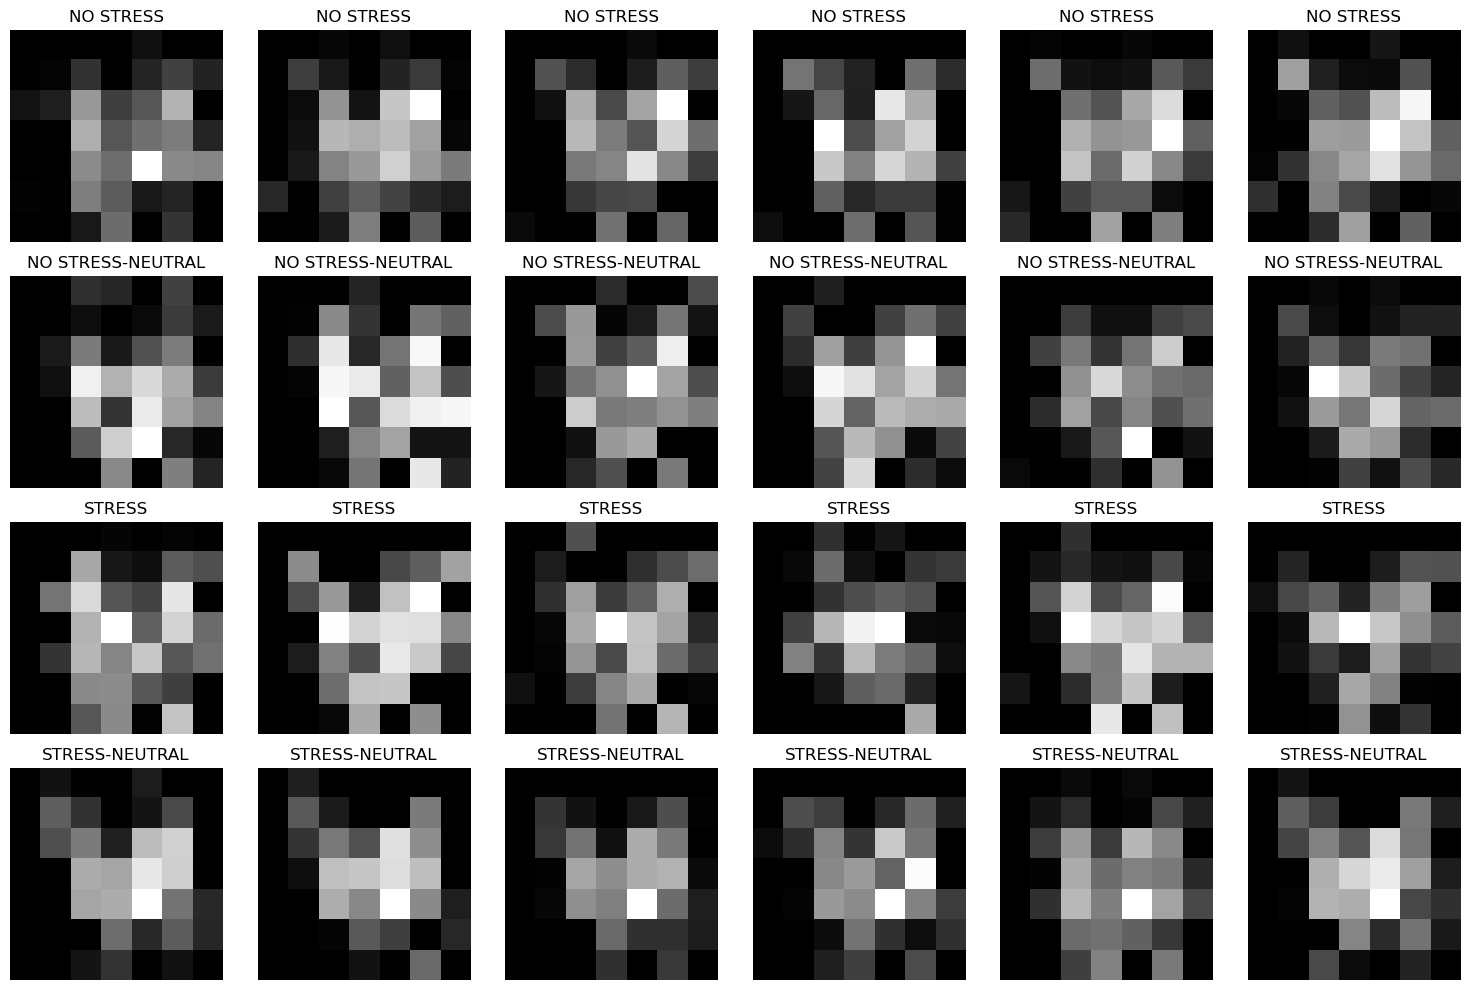

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10))
axes = axes.ravel()

etiquetas_indices = {'NO STRESS': 0, 'NO STRESS-NEUTRAL': 1, 'STRESS': 2, 'STRESS-NEUTRAL': 3}
contador = {key: 0 for key in etiquetas_indices.keys()}

# Supongamos que queremos visualizar el primer 'canal' de cada imagen
channel = 0  # Puedes cambiar esto para visualizar diferentes canales

for i in range(len(imagenes)):
    label = etiquetas[i]
    if contador[label] < 6:
        ax = axes[etiquetas_indices[label]*6 + contador[label]]
        # Visualizar el primer canal y asegurarse de que reshape es correcto
        ax.imshow(imagenes[i][channel].reshape(7, 7), cmap='gray')  # Ajusta el tamaño de reshape si es necesario
        ax.set_title(label)
        ax.axis('off')
        contador[label] += 1

plt.tight_layout()
plt.show()

